In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
from sympy.solvers import solve
import seaborn as sns
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
def PlotCM(V, filename):
    
    plt.figure(figsize=(10, 10), dpi=100)
    ax1 = plt.subplot(111)
    im1 = ax1.imshow(V, cmap='magma', aspect='auto', origin='lower', extent=[-25, 25, -25, 25])
    plt.xlabel('x ($\mu$m)', fontsize=13)
    plt.ylabel('y $\mu$m', fontsize=13)
    plt.xticks(np.arange(-25, 25, 10))
    plt.yticks(np.arange(-25, 25, 10))
    divider = make_axes_locatable(ax1)
    cax1 = divider.append_axes("right", size="5%", pad=0.1)
    cbar1 = plt.colorbar(im1, cax=cax1)
    cbar1.set_label('V (V)', fontsize=13)
    plt.savefig(filename)
    plt.show();

In [3]:
distance = 10e-4
x_elec = 25e-4
y_elec = 25e-4
elec_sub = np.sqrt(x_elec**2 + y_elec**2)
dt = 1e-6
x_cds = np.arange(-25e-4, 25e-4,dt)
y_cds = np.arange(-25e-4, 25e-4,dt)

In [4]:
grid = np.zeros((len(x_cds),len(y_cds)))
voltage = np.zeros((len(x_cds),len(y_cds)))

for i in range(0,len(x_cds)):
    for j in range(0,len(y_cds)):
        grid[i][j] = x_cds[i]*x_cds[i] + y_cds[j]*y_cds[j] + distance*distance
        voltage[i][j] = 0.3*1 / (4*np.pi*np.sqrt(grid[i][j]))



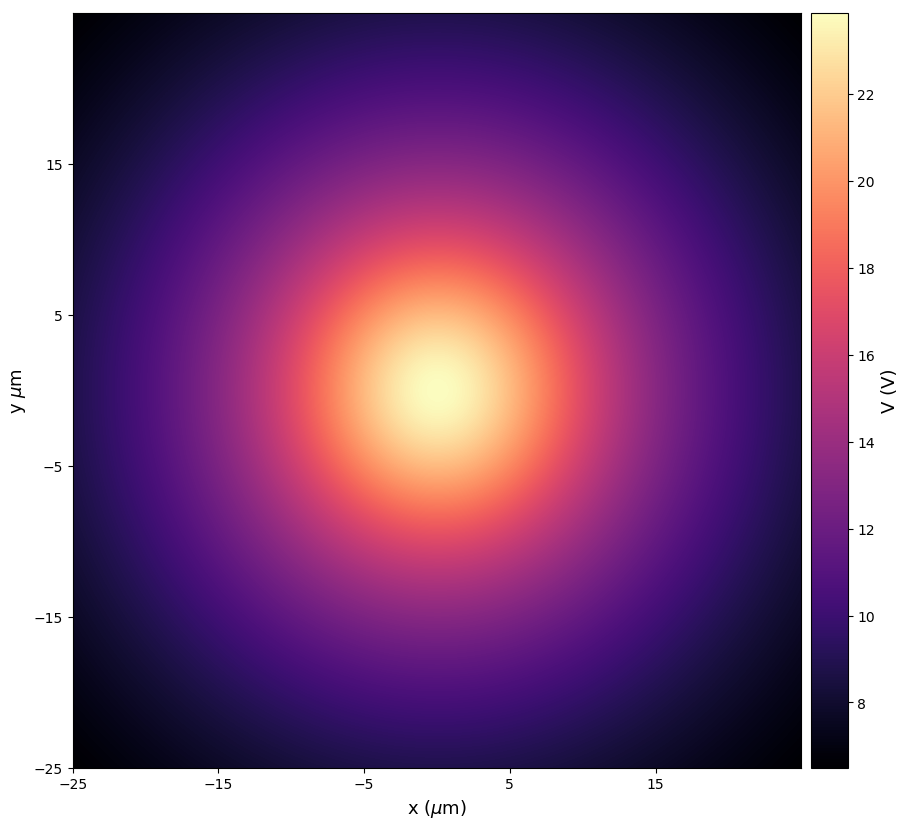

In [5]:
PlotCM(voltage, "voltage1_1.pdf")

In [255]:
grid_ax = np.zeros(len(x_cds))
voltage_ax = np.zeros(len(x_cds))
electricf_ax = np.zeros(len(x_cds))
activation_ax = np.zeros(len(x_cds))
grid_ax = np.sqrt(x_cds*x_cds + distance*distance)
voltage1_ax = 0.3*1 / (4*np.pi*grid_ax)
electricf1_ax = -np.gradient(voltage1_ax) 
activation1_ax = -np.gradient(electricf1_ax)

In [7]:
def Plot(x,y,label_des,ylabel,filename):
    plt.plot(x*10000, y, label=label_des)
    plt.xlabel("x ($\mu$m)")
    plt.ylabel(ylabel)
    plt.grid()
    plt.legend()
    plt.savefig(filename)
    plt.show()

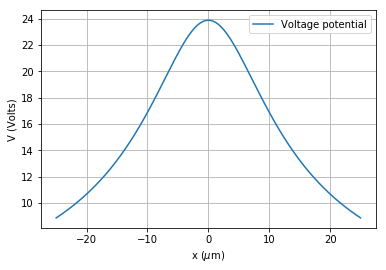

In [13]:
Plot(x_cds,voltage1_ax,"Voltage potential", "V (Volts)","Potential_1_2+1.pdf")

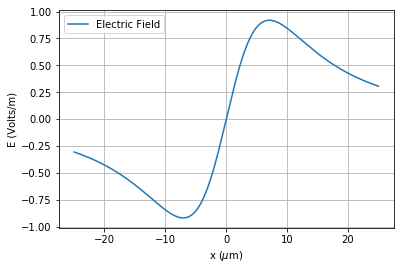

In [122]:
Plot(x_cds,electricf1_ax*100,"Electric Field", "E (Volts/m)","Electric_1_2+1.pdf")

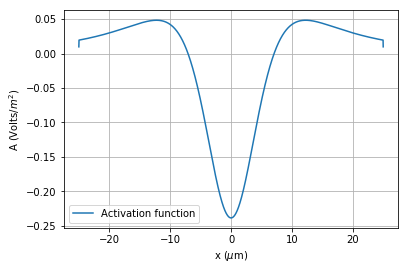

In [123]:
Plot(x_cds,activation1_ax*10000,"Activation function", "A (Volts/$m^2$)","Activation_1_2+1.pdf")

In [16]:
voltage2_ax = 0.3*-1 / (4*np.pi*grid_ax)
electricf2_ax = -np.gradient(voltage2_ax) 
activation2_ax = -np.gradient(electricf2_ax)

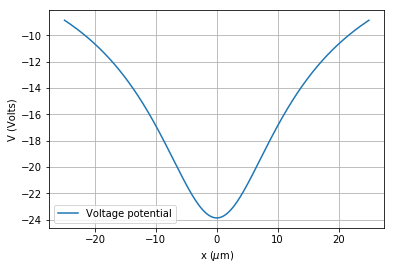

In [17]:
Plot(x_cds,voltage2_ax,"Voltage potential", "V (Volts)","Potential_1_2-1.pdf")

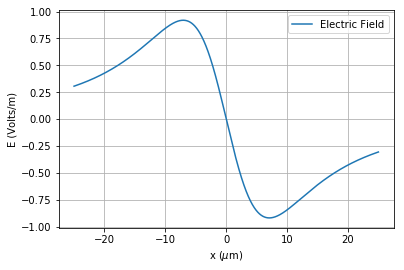

In [124]:
Plot(x_cds,electricf2_ax*100,"Electric Field", "E (Volts/m)","Electric_1_2-1.pdf")

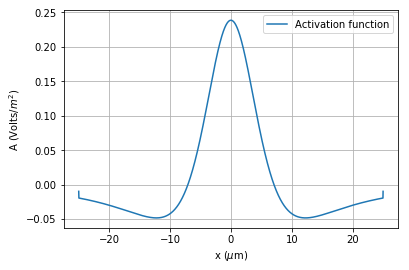

In [125]:
Plot(x_cds,activation2_ax*10000,"Activation function", "A (Volts/$m^2$)","Activation_1_2-1.pdf")

In [126]:
alpha_m = lambda V : (2.5 - 0.1 * (V)) / (np.exp(2.5 - 0.1 * (V)) - 1)
alpha_n = lambda V : (0.1 - 0.01 * (V)) / (np.exp(1 - 0.1 * (V)) - 1)
alpha_h = lambda V : 0.07* np.exp((V)/-20.0)

beta_m = lambda V : 4* np.exp((V)/-18.0)
beta_n = lambda V : 0.125* np.exp((V)/-80.0)
beta_h = lambda V : 1/(np.exp(3-0.1*(V)) + 1)

steady_state_m = lambda V: alpha_m(V)/(alpha_m(V) + beta_m(V))
steady_state_n = lambda V: alpha_n(V)/(alpha_n(V) + beta_n(V))
steady_state_h = lambda V: alpha_h(V)/(alpha_h(V) + beta_h(V))

k = lambda T: 3.0**(0.1*(T-6.3))
A_m = lambda V,temp: -1 * (alpha_m(V) + beta_m(V)) * k(temp)
B_m = lambda V,temp: alpha_m(V)*k(temp)
A_n = lambda V,temp: -1 * (alpha_n(V) + beta_n(V)) * k(temp)
B_n = lambda V,temp: alpha_n(V)*k(temp)
A_h = lambda V,temp: -1 * (alpha_h(V) + beta_h(V)) * k(temp)
B_h = lambda V,temp: alpha_h(V)*k(temp)

In [328]:
def IHHExp(num_comp, i_stim, T, V_init, m_init, n_init, h_init, V_Na, V_K, V_L, g_Na, g_K, g_L, C_m, R_a, dt, temp, A_m, B_m, A_n, B_n, A_h, B_h):
        
    Identity_vec = np.ones(num_comp)
    
    M = np.zeros((num_comp,len(T)))
    N = np.zeros((num_comp,len(T)))
    H = np.zeros((num_comp,len(T)))
    
    i_Na = np.zeros((num_comp,len(T)))
    i_K = np.zeros((num_comp,len(T)))
    i_L = np.zeros((num_comp,len(T)))
    
    V = np.zeros((num_comp,len(T)))
    
    M[:,0] = m_init*Identity_vec
    N[:,0] = n_init*Identity_vec
    H[:,0] = h_init*Identity_vec
    
    V[:,0] = V_init*Identity_vec
    
    V_Nam = V_Na * Identity_vec
    V_Km = V_K * Identity_vec
    V_Lm = V_L * Identity_vec

    combination = np.zeros((num_comp,num_comp))
    combination[0][0] = -1
    combination[0][1] = 1
    for i in range(1,num_comp-1):
        combination[i][i] = -2
        combination[i][i-1] = 1
        combination[i][i+1] = 1
    combination[i+1][i+1] = -1
    combination[i+1][i] = 1

    A = np.identity(num_comp) - (dt/(C_m*R_a))*combination

    for i in range(1,len(T)):
        M[:, i] = M[:, i-1]*np.exp(A_m(V[:, i-1],temp)*dt) + (B_m(V[:, i-1], temp)/A_m(V[:, i-1],temp))*(np.exp(A_m(V[:, i-1], temp)*dt)-1)
        N[:, i] = N[:, i-1]*np.exp(A_n(V[:, i-1],temp)*dt) + (B_n(V[:, i-1], temp)/A_n(V[:, i-1],temp))*(np.exp(A_n(V[:, i-1], temp)*dt)-1)
        H[:, i] = H[:, i-1]*np.exp(A_h(V[:, i-1],temp)*dt) + (B_h(V[:, i-1], temp)/A_h(V[:, i-1],temp))*(np.exp(A_h(V[:, i-1], temp)*dt)-1)
        
        i_Na[:,i] = g_Na*(M[:,i-1]**3)*H[:,i-1]*(V[:,i-1]-V_Nam)
        i_K[:,i] = g_K*(N[:,i-1]**4)*(V[:,i-1]-V_Km)
        i_L[:,i] = g_L*(V[:,i-1]-V_Lm)

        B = V[:, i-1] + (dt/C_m)*(-i_Na[:,i]-i_K[:,i]-i_L[:,i]) + (dt/(C_m*R_a))*np.dot(combination,i_stim[:,i])
#         print(B.shape)
        #         print(combination*i_stim[:,i])
        V[:,i] = np.linalg.solve(A,B)
        V[0] = 0
        V[-1] = 0
    
    return V

In [357]:
def getPotential(I,num_comp,grid_ax):
    
    voltage_ax = np.zeros((num_comp,len(I)))
    for i in range(0,len(I)):
        voltage_ax[:,i] = 0.3*I[i]/ (4*np.pi*grid_ax)
        
    return voltage_ax*1000

In [363]:
def getActivation(I,num_comp,grid_ax):
    
    a = np.zeros((num_comp,len(I)))
    for i in range(0,len(I)):
        voltage_ax = 0.3*I[i]/ (4*np.pi*grid_ax)
        e = -np.gradient(voltage_ax)
        a[:,i] = -np.gradient(e)
    return a

In [389]:
def PlotCM(V, filename):
    
    plt.figure(figsize=(10, 10), dpi=100)
    ax1 = plt.subplot(111)
    im1 = ax1.imshow(V, cmap='magma', aspect='auto', origin='lower', extent=[0, 30, 0, 100])
    plt.xlabel('t (ms)', fontsize=13)
    plt.ylabel('Compartment Nr.', fontsize=13)
    plt.xticks(np.arange(0, 31, 1))
    plt.yticks(np.arange(0, 101, 10))
    divider = make_axes_locatable(ax1)
    cax1 = divider.append_axes("right", size="5%", pad=0.1)
    cbar1 = plt.colorbar(im1, cax=cax1)
    cbar1.set_label('V (mV)', fontsize=13)
    plt.savefig(filename)
    plt.show();

In [371]:
def PlotAM(V, filename):
    
#     plt.figure(figsize=(10, 10), dpi=100)
    ax1 = plt.subplot(111)
    im1 = ax1.imshow(V, cmap='magma', aspect='auto', origin='lower', extent=[0, 30, 0, 100])
    plt.xlabel('t (ms)', fontsize=13)
    plt.ylabel('Compartment Nr.', fontsize=13)
    plt.xticks(np.arange(0, 31, 5))
    plt.yticks(np.arange(0, 101, 10))
    divider = make_axes_locatable(ax1)
    cax1 = divider.append_axes("right", size="5%", pad=0.1)
    cbar1 = plt.colorbar(im1, cax=cax1)
    cbar1.set_label('A (V/$m^2$)', fontsize=13)
    plt.savefig(filename)
    plt.show();

In [392]:
dt = 0.025
x_cds1 = np.arange(-25e-4, 25e-4,5e-5)
grid1_ax = np.sqrt(x_cds1*x_cds1 + distance*distance)
num_comp = 100
resistivity = 0.01
length = 0.5e-4
radius = 1.5e-4
tem1 = int(5/dt)
tem2 = tem1 + int(1/dt)


R_a = lambda ra, rhoa, la: ((rhoa * la)/(np.pi*ra*ra))
R_axon = R_a(radius,resistivity,length)


T = np.arange(0,30,dt)

I_stim1 = np.zeros(len(T))
I_stim1[tem1:tem2] = -0.25

I_stim2 = np.zeros(len(T))
I_stim2[tem1:tem2] = -1

I_stim3 = np.zeros(len(T))
I_stim3[tem1:tem2] = -0.5
tem3 = tem2 + int(1/dt)
I_stim3[tem2:tem3] = 0.5

I_stim4 = np.zeros(len(T))
I_stim4[tem1:tem2] = -2
I_stim4[tem2:tem3] = 2

I_stim5 = np.zeros(len(T))
I_stim5[tem1:tem2] = 0.25

I_stim6 = np.zeros(len(T))
I_stim6[tem1:tem2] = 5

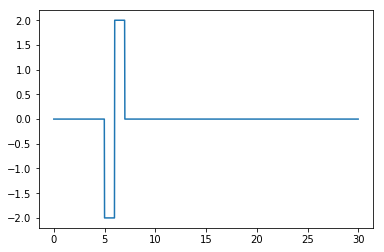

In [339]:
plt.plot(T,I_stim4)
plt.show()

In [275]:
V_init = 0
m_init = steady_state_m(V_init)
n_init = steady_state_n(V_init)
h_init = steady_state_h(V_init)


V_Na = 115
V_K = -12
V_L = 10.6
g_Na = 120
g_K = 36
g_L = 0.3
C_m = 1
V_rest = -70

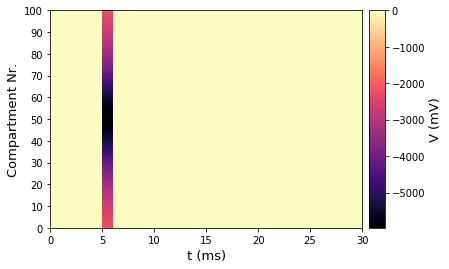

In [385]:
PlotCM(getPotential(I_stim1,num_comp,grid1_ax), "potential.pdf")

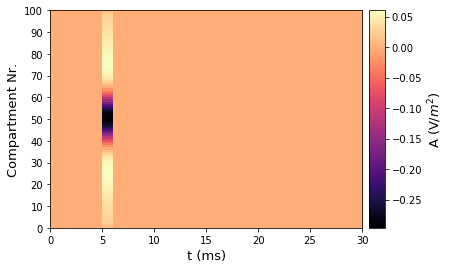

In [378]:
PlotAM(getActivation(I_stim6,num_comp,grid1_ax), "activation6.pdf")

In [387]:
V1 = IHHExp(num_comp, getPotential(I_stim1,num_comp,grid1_ax), T, V_init, m_init, n_init, h_init, V_Na, V_K, V_L, g_Na, g_K, g_L, C_m, R_axon, dt, 6.3, A_m, B_m, A_n, B_n, A_h, B_h)
V2 = IHHExp(num_comp, getPotential(I_stim2,num_comp,grid1_ax), T, V_init, m_init, n_init, h_init, V_Na, V_K, V_L, g_Na, g_K, g_L, C_m, R_axon, dt, 6.3, A_m, B_m, A_n, B_n, A_h, B_h)
V3 = IHHExp(num_comp, getPotential(I_stim3,num_comp,grid1_ax), T, V_init, m_init, n_init, h_init, V_Na, V_K, V_L, g_Na, g_K, g_L, C_m, R_axon, dt, 6.3, A_m, B_m, A_n, B_n, A_h, B_h)
V4 = IHHExp(num_comp, getPotential(I_stim4,num_comp,grid1_ax), T, V_init, m_init, n_init, h_init, V_Na, V_K, V_L, g_Na, g_K, g_L, C_m, R_axon, dt, 6.3, A_m, B_m, A_n, B_n, A_h, B_h)
V5 = IHHExp(num_comp, getPotential(I_stim5,num_comp,grid1_ax), T, V_init, m_init, n_init, h_init, V_Na, V_K, V_L, g_Na, g_K, g_L, C_m, R_axon, dt, 6.3, A_m, B_m, A_n, B_n, A_h, B_h)
V6 = IHHExp(num_comp, getPotential(I_stim6,num_comp,grid1_ax), T, V_init, m_init, n_init, h_init, V_Na, V_K, V_L, g_Na, g_K, g_L, C_m, R_axon, dt, 6.3, A_m, B_m, A_n, B_n, A_h, B_h)

In [341]:
np.max(V5)

0.41176129118640448

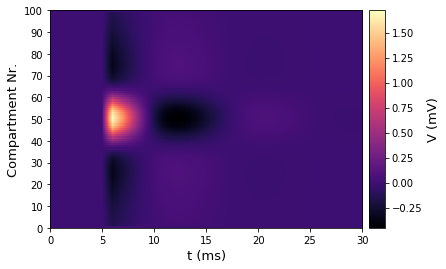

In [360]:
PlotCM(V1, 'voltage1.pdf')

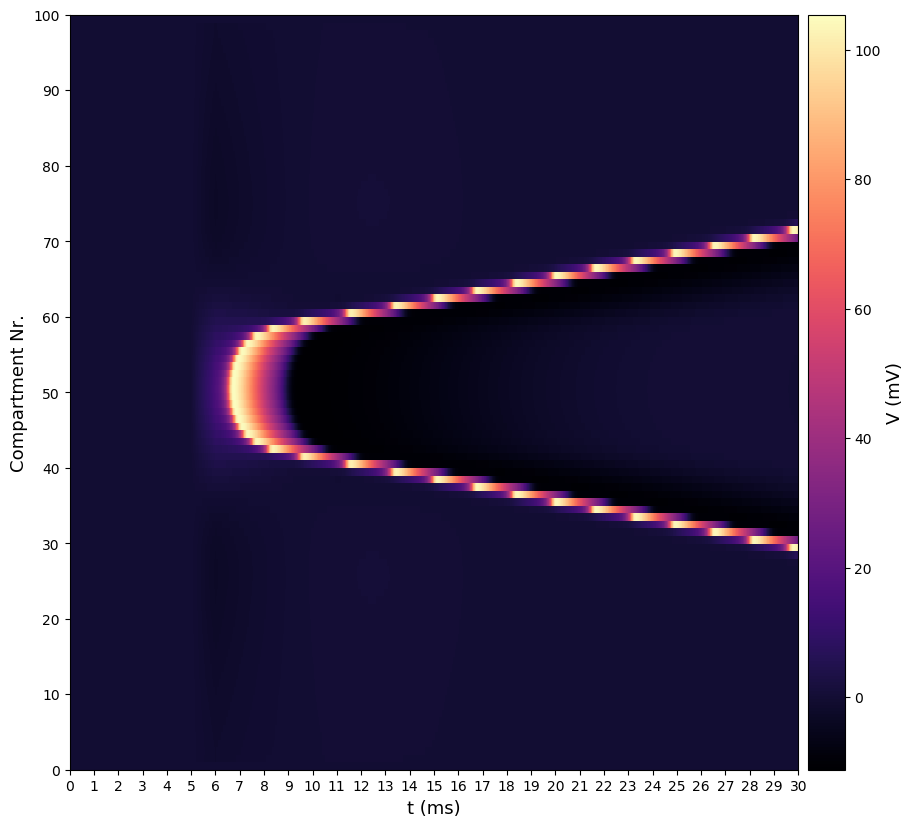

In [391]:
PlotCM(V2, 'voltage2.pdf')

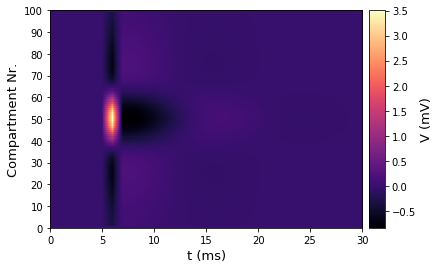

In [351]:
PlotCM(V3, 'voltage3.pdf')

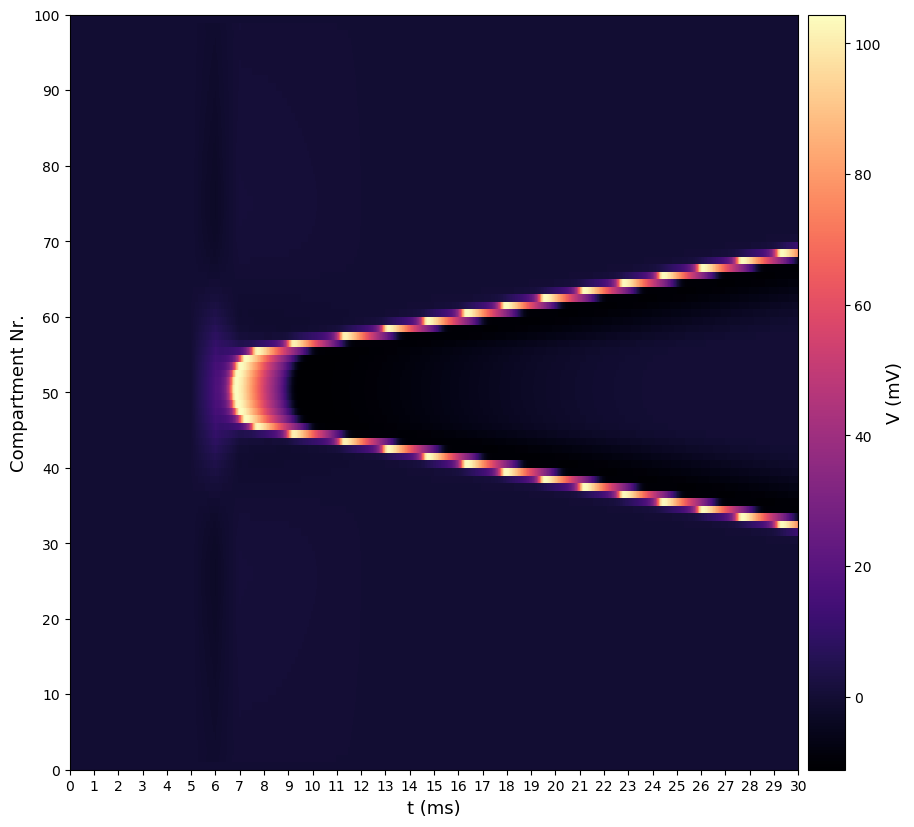

In [390]:
PlotCM(V4, 'voltage4.pdf')

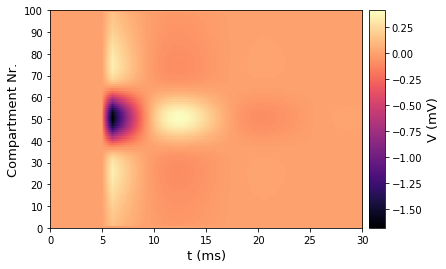

In [353]:
PlotCM(V5, 'voltage5.pdf')

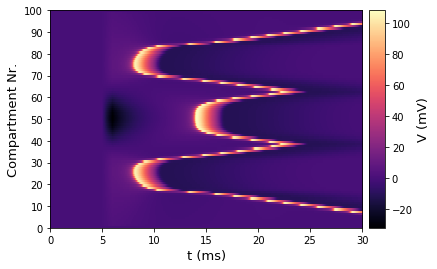

In [354]:
PlotCM(V6, 'voltage6.pdf')